# How have BPD paychecks changed year-over-year?

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns

In [9]:
plt.rcParams['font.family'] = 'Arial'

In [10]:
years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
data_folder_path = '../data/earning/'
file_paths = [
    "2014_earnings.csv", "2015_earnings.csv", "2016_earnings.csv", "2017_earnings.csv", "2018_earnings.csv", "2019_earnings.csv","2020_earnings.csv", "2021_earnings.csv", "2022_earnings.csv", "2023_earnings.csv", "2024_earnings.csv"
]
file_paths = [data_folder_path + file_path for file_path in file_paths]

In [11]:
# Remove symbols in currency values and convert to float
def clean_currency(val):
    if isinstance(val, str):
        val = val.replace('$', '').replace(',', '').replace('(','').replace(')','').strip()
        if val == '-' or val == '0.00':
            return None
        return float(val)
    return val

In [12]:
# Read and process each CSV file
dfs = []
currency_columns = ['REGULAR','OTHER','OVERTIME','INJURED','DETAIL','QUINN_EDUCATION','TOTAL_GROSS']

for year, path in zip(years, file_paths):
    df = pd.read_csv(path, encoding='ISO-8859-1')
    df['YEAR'] = year
    print(year)
    for col in currency_columns:
        if col in df.columns:
            # Clean the currency columns
            df[col] = df[col].apply(clean_currency)
        else:
            print(f"Warning: Column '{col}' not found in {year} data.")

    dfs.append(df)

2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


In [13]:
# Concatenate all year dataframes into a single dataframe
full_data = pd.concat(dfs, ignore_index=True)

# Check for missing values
missing_values = full_data.isnull().sum()
print("Missing values in each column:")
print(missing_values)
full_data['DEPARTMENT_NAME'] = full_data['DEPARTMENT_NAME'].fillna('')

# Remove rows missing TOTAL_GROSS
full_data = full_data.dropna(subset=['TOTAL_GROSS'])

# Print the stats of the full dataset
print("Full dataset statistics:")
print(full_data.describe(include='all'))

# Seperate BPD and non-BPD data
bpd_data = full_data[full_data['DEPARTMENT_NAME'].str.upper().str.contains('POLICE')]
non_bpd_data = full_data[~full_data['DEPARTMENT_NAME'].str.upper().str.contains('POLICE')]

Missing values in each column:
NAME                    6
TITLE                   6
DEPARTMENT_NAME         6
REGULAR             10800
RETRO              143778
OTHER               99389
OVERTIME           177839
INJURED            237529
DETAIL             229035
QUINN_EDUCATION    239579
TOTAL_GROSS             8
POSTAL                201
YEAR                    0
dtype: int64
Full dataset statistics:
                    NAME    TITLE           DEPARTMENT_NAME        REGULAR   
count             254289   254289                    254289  243497.000000  \
unique             47932     2553                       435            NaN   
top     Sullivan,Michael  Teacher  Boston Police Department            NaN   
freq                  38    59173                     34697            NaN   
mean                 NaN      NaN                       NaN   67428.426415   
std                  NaN      NaN                       NaN   41340.984065   
min                  NaN      NaN              

In [14]:
# Calcaulate average gross
bpd_avg = bpd_data.groupby('YEAR')['TOTAL_GROSS'].mean().reset_index(name='BPD_AVG_GROSS')
non_bpd_avg = non_bpd_data.groupby('YEAR')['TOTAL_GROSS'].mean().reset_index(name='NON_BPD_AVG_GROSS')

avg_comparison = pd.merge(bpd_avg, non_bpd_avg, on='YEAR', how='outer').sort_values('YEAR')

avg_comparison

,YEAR,BPD_AVG_GROSS,NON_BPD_AVG_GROSS
0,2014,112589.650642,59304.269696
1,2015,118041.488626,63268.735794
2,2016,124787.164775,62942.269980
3,2017,124254.563280,62820.904814
4,2018,131321.462320,63828.300246
5,2019,127094.346316,68909.359765
6,2020,132487.610436,74998.581716
7,2021,132114.566694,74947.610265
8,2022,133494.427569,75620.021611
9,2023,138366.695543,75703.959911


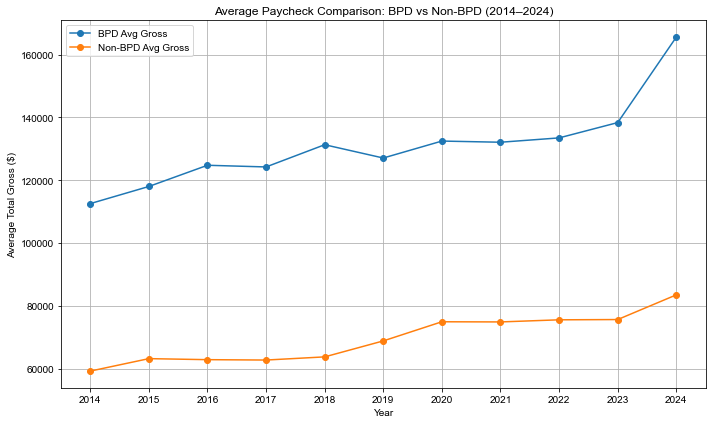

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(avg_comparison['YEAR'], avg_comparison['BPD_AVG_GROSS'], marker='o', label='BPD Avg Gross')
plt.plot(avg_comparison['YEAR'], avg_comparison['NON_BPD_AVG_GROSS'], marker='o', label='Non-BPD Avg Gross')
plt.title('Average Paycheck Comparison: BPD vs Non-BPD (2014–2024)')
plt.xlabel('Year')
plt.ylabel('Average Total Gross ($)')
plt.grid(True)
plt.legend()
plt.xticks(avg_comparison['YEAR'])
plt.tight_layout()
plt.show()

# How much BPD officer pay came from injury pay?

In [16]:
# Drop rows with missing INJURED values
bpd_data_dropna = bpd_data.dropna(subset=['INJURED'])

# Calculate the ratio of injured pay to total gross
bpd_data_dropna['INJURED_RATIO'] = bpd_data_dropna['INJURED'] / bpd_data_dropna['TOTAL_GROSS']


/var/folders/64/dkndw9l10ls5pdzpx8fmcqpc0000gn/T/ipykernel_20732/3637093187.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bpd_data_dropna['INJURED_RATIO'] = bpd_data_dropna['INJURED'] / bpd_data_dropna['TOTAL_GROSS']


/var/folders/64/dkndw9l10ls5pdzpx8fmcqpc0000gn/T/ipykernel_20732/1374641421.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='YEAR', y='INJURED_RATIO', data=bpd_data_dropna, palette='Set3')


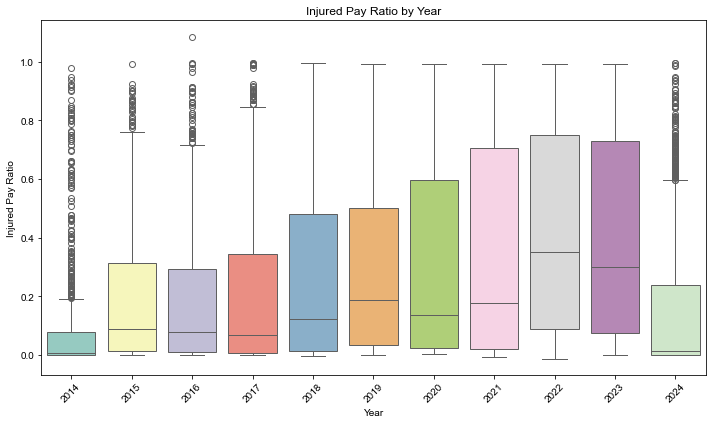

In [17]:
# Plot boxplot of injured pay ratio per year
plt.figure(figsize=(10, 6))
sns.boxplot(x='YEAR', y='INJURED_RATIO', data=bpd_data_dropna, palette='Set3')
plt.title('Injured Pay Ratio by Year')
plt.xlabel('Year')
plt.ylabel('Injured Pay Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
# Calculate the average injured ratio per year
injured_ratio_avg = bpd_data_dropna['INJURED_RATIO'].groupby(bpd_data_dropna['YEAR']).mean().reset_index(name='INJURED_RATIO')

injured_ratio_avg

,YEAR,INJURED_RATIO
0,2014,0.093860
1,2015,0.217756
2,2016,0.212965
3,2017,0.229184
4,2018,0.264143
5,2019,0.292817
6,2020,0.299839
7,2021,0.329436
8,2022,0.415957
9,2023,0.389215


/var/folders/64/dkndw9l10ls5pdzpx8fmcqpc0000gn/T/ipykernel_20732/3570248617.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='YEAR', y='INJURED_RATIO', data=injured_ratio_avg, palette='Set2')


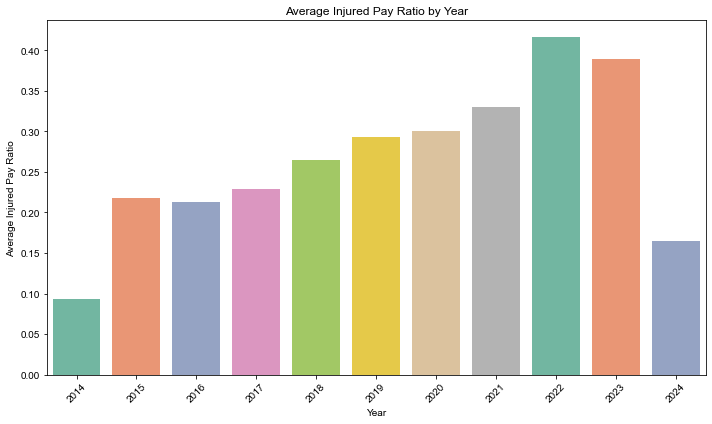

In [19]:
# Plot the average injured ratio per year
plt.figure(figsize=(10, 6))
sns.barplot(x='YEAR', y='INJURED_RATIO', data=injured_ratio_avg, palette='Set2')
plt.title('Average Injured Pay Ratio by Year')
plt.xlabel('Year')
plt.ylabel('Average Injured Pay Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# What percentage of officers took injury pay in a given year? 

In [20]:
# Count the number of injured officers each year
injured_counts = bpd_data_dropna.groupby('YEAR')['INJURED'].count().reset_index(name='INJURED_COUNT')
counts = bpd_data.groupby('YEAR')['TOTAL_GROSS'].count().reset_index(name='COUNT')
injured_counts = pd.merge(injured_counts, counts, on='YEAR', how='outer')

#  Calculate the percentage of injured officers
injured_counts['INJURED_PERCENTAGE'] = (injured_counts['INJURED_COUNT'] / injured_counts['COUNT']) * 100

injured_counts


,YEAR,INJURED_COUNT,COUNT,INJURED_PERCENTAGE
0,2014,830,3178,26.117055
1,2015,342,3034,11.272248
2,2016,449,3114,14.418754
3,2017,475,3149,15.084154
4,2018,461,3173,14.528837
5,2019,458,3271,14.001834
6,2020,647,3142,20.591980
7,2021,647,3094,20.911441
8,2022,459,3040,15.098684
9,2023,406,3011,13.483892


/var/folders/64/dkndw9l10ls5pdzpx8fmcqpc0000gn/T/ipykernel_20732/1055180194.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='YEAR', y='INJURED_PERCENTAGE', data=injured_counts, palette='Set2')


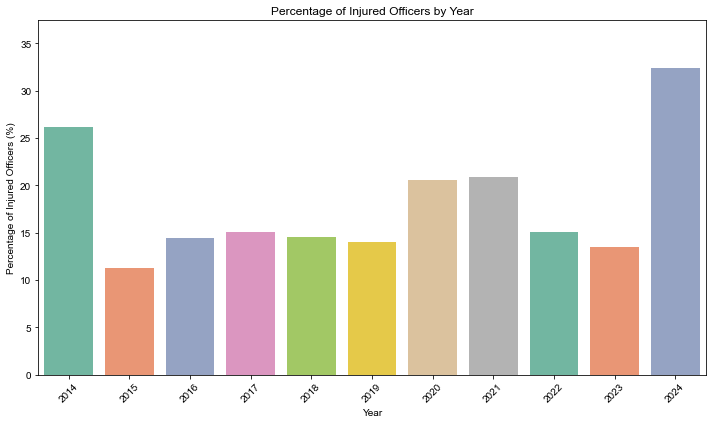

In [21]:

# Plot the percentage of injured officers by year
plt.figure(figsize=(10, 6))
sns.barplot(x='YEAR', y='INJURED_PERCENTAGE', data=injured_counts, palette='Set2')
plt.title('Percentage of Injured Officers by Year')
plt.xlabel('Year')
plt.ylabel('Percentage of Injured Officers (%)')
plt.xticks(rotation=45)
plt.ylim(0, injured_counts['INJURED_PERCENTAGE'].max() + 5)  # Add some space above the max value
plt.tight_layout()
plt.show()

In [22]:
injured_counts['INJURED_PERCENTAGE'].describe()

count    11.000000
mean     17.994102
std       6.423665
min      11.272248
25%      14.210294
50%      15.084154
75%      20.751711
max      32.426239
Name: INJURED_PERCENTAGE, dtype: float64